### Imports iniciais

In [32]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer # Adicionado

# Carregar dados dos Alunos
df_path = "/Users/daniels/Documents/CEIA/PACTO/sim_dataset/alunos_based/data/full_dataset.csv"
df_alunos = pd.read_csv(df_path)

# Drop duplicates baseado em '_chave' e 'cliente_codigo'
df_alunos = df_alunos.drop_duplicates(subset=['_chave', 'cliente_codigo'])
df_alunos

,cliente_codigo,_chave,media_treinos_semanais,tendencia_num_treinos,duracao_media_treinos,pessoa_codigo,foi_indicado,sexo,ano_nascimento,num_convites_enviados,num_convites_recebidos,name,Philanthropist,Socialiser,Achiever,Player,Free Spirit,Disruptor,pred_dominant_hexad,pred_secondary_hexad
0,7459.0,28359f7fc700f9b9904a3b619c84022c,2.076923,-0.029541,88.421974,112303,False,1,1983,0.0,0.0,João Almeida,6.0,6.0,7.0,7.0,6.0,5.0,Achiever,Player
2,7326.0,ef9f2365f60ac8e2356e254c8c91488f,2.421053,0.058255,62.634316,8100,False,-1,1993,0.0,0.0,Clara Silva,7.0,7.0,6.0,5.0,6.0,3.0,Philanthropist,Socialiser
4,5062.0,ca13bee745eaeffb2c494385eeec9a47,2.120000,-0.074332,60.365232,21528,False,1,1989,0.0,0.0,Carlos Menezes,7.0,6.0,6.5,6.0,6.0,2.5,Philanthropist,Achiever
6,6180.0,ef9f2365f60ac8e2356e254c8c91488f,1.000000,0.000000,74.769767,6900,False,1,1987,0.0,0.0,Lucas,7.0,6.0,6.0,4.0,7.0,6.5,Philanthropist,Free Spirit
8,5458.0,ef9f2365f60ac8e2356e254c8c91488f,2.000000,-0.009946,53.048552,6115,False,-1,1994,0.0,0.0,Laura,6.0,5.0,7.0,6.0,7.0,4.0,Achiever,Free Spirit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,5543.0,ef9f2365f60ac8e2356e254c8c91488f,2.095238,0.005602,44.813269,6213,False,1,1997,0.0,0.0,Carlos,6.0,5.0,7.0,6.0,7.0,4.0,Achiever,Free Spirit
146,14657.0,1d40882bc4bd32e41d71d18381755f93,2.360000,0.013077,67.948483,119546,False,1,1995,0.0,0.0,Lucas Almeida,6.0,4.0,7.0,5.5,7.0,4.0,Achiever,Free Spirit
147,10856.0,33fa79e54690bc45beb83343f7e3c730,1.500000,-0.285714,57.864115,11222,False,1,2007,0.0,0.0,Rodrigo,6.0,4.0,7.0,7.0,6.0,2.5,Achiever,Player
148,11254.0,a855c5c74458a07ac7301a1a8df5b7ed,3.000000,1.500000,107.035579,11808,False,-1,1978,0.0,0.0,Laura Valente,6.0,3.0,7.0,6.0,7.0,5.5,Achiever,Free Spirit


In [33]:
# Renomeia as colunas para lowercase e troca espacos por underline
df_alunos.columns = df_alunos.columns.str.lower().str.replace(' ', '_')

## Pré processamento

### User - Alunos

In [34]:
# Identificador único para alunos
df_alunos['user_id'] = df_alunos['_chave'].astype(str) + df_alunos['cliente_codigo'].astype(float).astype(int).astype(str)
df_alunos = df_alunos.drop(columns=['_chave', 'cliente_codigo'])

# One-hot encode do sexo
df_alunos = pd.get_dummies(df_alunos, columns=["sexo"], prefix="sexo")

# Converte a coluna 'foi_indicado' para float (0.0/1.0)
df_alunos['foi_indicado'] = df_alunos['foi_indicado'].astype(float)

# Colunas HEXAD (usadas para perfil do aluno e features do item)
hexad_cols = ['philanthropist', 'socialiser', 'achiever', 'player', 'free_spirit', 'disruptor']

# Adiciona um identificador da tabela de alunos para as colunas HEXAD
df_alunos.rename(columns={col: f'aluno_{col}' for col in hexad_cols}, inplace=True)

hexad_alunos_cols = [f'aluno_{col}' for col in hexad_cols]  # Atualiza os nomes das colunas HEXAD

# Colunas de features do aluno para a UserTower
# Inclui features demográficas, comportamentais e os próprios scores HEXAD do aluno
user_numeric_cols_for_scaling = [
    'media_treinos_semanais', 'tendencia_num_treinos', 'duracao_media_treinos',
    'ano_nascimento', 'num_convites_enviados', 'num_convites_recebidos'
]
# Adiciona colunas 'sexo' que foram criadas pelo get_dummies
sexo_cols = [col for col in df_alunos.columns if col.startswith('sexo_')]
user_categorical_cols = ['foi_indicado'] + sexo_cols

# Features finais do usuário (colunas de input para a UserTower)
final_user_feature_cols = []
# Adiciona colunas numéricas que precisam de scaling (e existem no DataFrame)
final_user_feature_cols.extend([col for col in user_numeric_cols_for_scaling if col in df_alunos.columns])
# Adiciona colunas categóricas já em formato 0/1 (e existem no DataFrame)
final_user_feature_cols.extend([col for col in user_categorical_cols if col in df_alunos.columns])
# Adiciona scores HEXAD do aluno como features (e existem no DataFrame)
final_user_feature_cols.extend([col for col in hexad_alunos_cols if col in df_alunos.columns])


# Remover coluna 'index' se existir (artefato do pandas read_csv)
if 'index' in df_alunos.columns:
    df_alunos = df_alunos.drop(columns=['index'])

# Divisão dos dados dos alunos para criar conjuntos de treino/validação de interações
df_alunos_train_users, df_val_users = train_test_split(df_alunos, test_size=0.3, random_state=42)

# Scaling das features numéricas dos alunos (NÃO HEXAD)
scaler = StandardScaler()
cols_to_scale_in_user_features = [col for col in user_numeric_cols_for_scaling if col in df_alunos_train_users.columns]

if cols_to_scale_in_user_features:
    # Converta as colunas para float ANTES de escalar
    for col in cols_to_scale_in_user_features:
        df_alunos_train_users[col] = df_alunos_train_users[col].astype(float)
        df_val_users[col] = df_val_users[col].astype(float)

    # Agora, fite o scaler e transforme
    scaler.fit(df_alunos_train_users[cols_to_scale_in_user_features])
    df_alunos_train_users.loc[:, cols_to_scale_in_user_features] = scaler.transform(df_alunos_train_users[cols_to_scale_in_user_features])
    df_val_users.loc[:, cols_to_scale_in_user_features] = scaler.transform(df_val_users[cols_to_scale_in_user_features])

### Items - Desafios

In [35]:
df_interactions_path = "/Users/daniels/Documents/CEIA/PACTO/sim_dataset/ratings_data/sim_20250603_234652_hexad_interactions.csv"
df_interactions = pd.read_csv(df_interactions_path)

df_interactions

,user_id,hexad_type,challenge_id,challenge_type,challenge_desc,date,event,success,streak,progress_pct,rating
0,28359f7fc700f9b9904a3b619c84022c7459,Achiever,7,Player,Complete 3 workouts with 100% execution and 5 ...,2025-05-14,workout_completed,True,1,12.5,1.0
1,28359f7fc700f9b9904a3b619c84022c7459,Achiever,7,Player,Complete 3 workouts with 100% execution and 5 ...,2025-05-15,skip,False,0,12.5,1.0
2,28359f7fc700f9b9904a3b619c84022c7459,Achiever,7,Player,Complete 3 workouts with 100% execution and 5 ...,2025-05-16,skip,False,0,12.5,1.0
3,28359f7fc700f9b9904a3b619c84022c7459,Achiever,7,Player,Complete 3 workouts with 100% execution and 5 ...,2025-05-17,skip,False,0,12.5,1.0
4,28359f7fc700f9b9904a3b619c84022c7459,Achiever,7,Player,Complete 3 workouts with 100% execution and 5 ...,2025-05-18,workout_completed,True,1,25.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2247,33fa79e54690bc45beb83343f7e3c730153,Free Spirit,1,Player,Complete 10 workouts in 14 days and unlock a b...,2025-05-13,skip,False,0,10.0,3.0
2248,33fa79e54690bc45beb83343f7e3c730153,Free Spirit,1,Player,Complete 10 workouts in 14 days and unlock a b...,2025-05-14,created_routine,False,0,10.0,3.0
2249,33fa79e54690bc45beb83343f7e3c730153,Free Spirit,1,Player,Complete 10 workouts in 14 days and unlock a b...,2025-05-15,skip,False,0,10.0,3.0
2250,33fa79e54690bc45beb83343f7e3c730153,Free Spirit,1,Player,Complete 10 workouts in 14 days and unlock a b...,2025-05-16,created_routine,True,1,20.0,3.0


In [36]:
df_interactions = df_interactions.rename(columns={'challenge_type': 'hexad_desafio', 'challenge_id': 'item_id', 'hexad_type': 'hexad_aluno'})

df_interactions = df_interactions.drop(columns=['hexad_aluno'])

# 'hexad_desafio' to one-hot encode
df_interactions = pd.get_dummies(df_interactions, columns=['hexad_desafio'], prefix='desafio')
df_interactions.columns = df_interactions.columns.str.lower().str.replace(' ', '_')

hexad_desafio_cols = [col for col in df_interactions.columns if col.startswith('desafio_')]
df_interactions

,user_id,item_id,challenge_desc,date,event,success,streak,progress_pct,rating,desafio_achiever,desafio_disruptor,desafio_free_spirit,desafio_philanthropist,desafio_player,desafio_socialiser
0,28359f7fc700f9b9904a3b619c84022c7459,7,Complete 3 workouts with 100% execution and 5 ...,2025-05-14,workout_completed,True,1,12.5,1.0,False,False,False,False,True,False
1,28359f7fc700f9b9904a3b619c84022c7459,7,Complete 3 workouts with 100% execution and 5 ...,2025-05-15,skip,False,0,12.5,1.0,False,False,False,False,True,False
2,28359f7fc700f9b9904a3b619c84022c7459,7,Complete 3 workouts with 100% execution and 5 ...,2025-05-16,skip,False,0,12.5,1.0,False,False,False,False,True,False
3,28359f7fc700f9b9904a3b619c84022c7459,7,Complete 3 workouts with 100% execution and 5 ...,2025-05-17,skip,False,0,12.5,1.0,False,False,False,False,True,False
4,28359f7fc700f9b9904a3b619c84022c7459,7,Complete 3 workouts with 100% execution and 5 ...,2025-05-18,workout_completed,True,1,25.0,1.0,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,33fa79e54690bc45beb83343f7e3c730153,1,Complete 10 workouts in 14 days and unlock a b...,2025-05-13,skip,False,0,10.0,3.0,False,False,False,False,True,False
2248,33fa79e54690bc45beb83343f7e3c730153,1,Complete 10 workouts in 14 days and unlock a b...,2025-05-14,created_routine,False,0,10.0,3.0,False,False,False,False,True,False
2249,33fa79e54690bc45beb83343f7e3c730153,1,Complete 10 workouts in 14 days and unlock a b...,2025-05-15,skip,False,0,10.0,3.0,False,False,False,False,True,False
2250,33fa79e54690bc45beb83343f7e3c730153,1,Complete 10 workouts in 14 days and unlock a b...,2025-05-16,created_routine,True,1,20.0,3.0,False,False,False,False,True,False


In [37]:
# Carregar modelo de embedding
embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # Você pode escolher outros modelos

# Gerar embeddings para 'challenge_desc'
# Certifique-se de que não há NaNs ou converta-os para string vazia
df_interactions['challenge_desc'] = df_interactions['challenge_desc'].fillna('') 
challenge_desc_embeddings = embedding_model.encode(df_interactions['challenge_desc'].tolist())

# Adicionar embeddings ao DataFrame
# Cada dimensão do embedding se tornará uma nova coluna
embedding_dim_size = challenge_desc_embeddings.shape[1]
embedding_cols = [f'desc_emb_{i}' for i in range(embedding_dim_size)]
df_interactions = pd.concat(
    [df_interactions, pd.DataFrame(challenge_desc_embeddings, index=df_interactions.index, columns=embedding_cols)],
    axis=1
).copy()

# Atualizar item_feature_cols para incluir 'hexad_desafio' e as novas colunas de embedding
# Mantendo 'hexad_desafio' se ainda for relevante, ou ajuste conforme necessário.
# Se 'challenge_desc' original não for mais necessária como feature direta, remova-a.
item_feature_cols = hexad_desafio_cols + embedding_cols

# Remover a coluna original 'challenge_desc' se os embeddings a substituem completamente como feature
# df_interactions = df_interactions.drop(columns=['challenge_desc'])


In [38]:
def create_engagement_score(success, rating, weight_success=0.6, weight_rating=0.4):
    """
    Cria um score de engajamento mais sofisticado
    """
    normalized_rating = rating / 10.0
    # Penaliza ratings muito baixos mesmo com sucesso
    penalty = np.where(rating < 3, 0.5, 1.0)
    
    score = (success.astype(float) * weight_success + 
             normalized_rating * weight_rating) * penalty
    
    return np.clip(score, 0, 1)

df_interactions['label'] = create_engagement_score(
    df_interactions['success'], 
    df_interactions['rating']
)

In [39]:
train_interactions_df = pd.merge(df_alunos_train_users, df_interactions, on='user_id', how='left')

val_interactions_df = pd.merge(df_val_users, df_interactions, on='user_id', how='left')

In [31]:
train_interactions_df

,media_treinos_semanais,tendencia_num_treinos,duracao_media_treinos,pessoa_codigo,foi_indicado,ano_nascimento,num_convites_enviados,num_convites_recebidos,name,aluno_philanthropist,...,desc_emb_380,desc_emb_381,desc_emb_382,desc_emb_383,label,streak_normalized,progress_normalized,user_avg_streak,user_avg_progress,user_success_rate
1358,-0.525302,0.174920,-0.797547,118377,0.0,-0.472597,-0.120386,0.0,Carlos,6.0,...,0.106266,-0.056690,-0.046650,0.030542,0.0,0.0,0.0,0.000000,50.000000,0.500000
1359,-0.525302,0.174920,-0.797547,118377,0.0,-0.472597,-0.120386,0.0,Carlos,6.0,...,0.106266,-0.056690,-0.046650,0.030542,0.0,0.0,0.0,0.000000,0.000000,0.000000
1360,-0.525302,0.174920,-0.797547,118377,0.0,-0.472597,-0.120386,0.0,Carlos,6.0,...,0.106266,-0.056690,-0.046650,0.030542,0.3,0.1,0.1,0.000000,0.000000,0.000000
1361,-0.525302,0.174920,-0.797547,118377,0.0,-0.472597,-0.120386,0.0,Carlos,6.0,...,0.106266,-0.056690,-0.046650,0.030542,0.3,0.2,0.2,0.333333,3.333333,0.333333
1362,-0.525302,0.174920,-0.797547,118377,0.0,-0.472597,-0.120386,0.0,Carlos,6.0,...,0.106266,-0.056690,-0.046650,0.030542,0.3,0.3,0.3,0.750000,7.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,-0.377550,2.303579,-0.381188,9996,0.0,0.153557,-0.120386,0.0,Marina Lima,6.0,...,0.055429,0.013588,0.007407,-0.039588,0.0,0.0,0.3,0.312500,21.250000,0.312500
710,-0.377550,2.303579,-0.381188,9996,0.0,0.153557,-0.120386,0.0,Marina Lima,6.0,...,0.055429,0.013588,0.007407,-0.039588,0.0,0.0,0.3,0.294118,21.764706,0.294118
711,-0.377550,2.303579,-0.381188,9996,0.0,0.153557,-0.120386,0.0,Marina Lima,6.0,...,0.055429,0.013588,0.007407,-0.039588,0.3,0.1,0.4,0.277778,22.222222,0.277778
712,-0.377550,2.303579,-0.381188,9996,0.0,0.153557,-0.120386,0.0,Marina Lima,6.0,...,0.055429,0.013588,0.007407,-0.039588,0.0,0.0,0.4,0.315789,23.157895,0.315789


In [42]:
def add_feedback_data(df):
    """
    Adiciona dados de feedback ao DataFrame de interações.
    """
    
    # Normalizar streak e progress_pct
    df['streak_normalized'] = df['streak'] / (df['streak'].max() + 1e-8)
    df['progress_normalized'] = df['progress_pct'] / 100.0

    # Features de contexto do usuário (baseadas no histórico)
    df = df.sort_values(['user_id', 'date'])

    # Streak médio histórico do usuário
    df['user_avg_streak'] = df.groupby('user_id')['streak'].transform(
        lambda x: x.expanding().mean().shift(1)
    ).fillna(0)

    # Progresso médio histórico do usuário
    df['user_avg_progress'] = df.groupby('user_id')['progress_pct'].transform(
        lambda x: x.expanding().mean().shift(1)
    ).fillna(50.0)

    # Taxa de sucesso histórica do usuário
    df['user_success_rate'] = df.groupby('user_id')['success'].transform(
        lambda x: x.expanding().mean().shift(1)
    ).fillna(0.5)

    return df

train_interactions_df = add_feedback_data(train_interactions_df)
val_interactions_df = add_feedback_data(val_interactions_df)

In [43]:
# Adicionar às features do usuário (histórico)
user_history_features = ['user_avg_streak', 'user_avg_progress', 'user_success_rate']
final_user_feature_cols.extend(user_history_features)

In [45]:
train_interactions_df[final_user_feature_cols]

,media_treinos_semanais,tendencia_num_treinos,duracao_media_treinos,ano_nascimento,num_convites_enviados,num_convites_recebidos,foi_indicado,sexo_-1,sexo_0,sexo_1,aluno_philanthropist,aluno_socialiser,aluno_achiever,aluno_player,aluno_free_spirit,aluno_disruptor,user_avg_streak,user_avg_progress,user_success_rate
1358,-0.525302,0.174920,-0.797547,-0.472597,-0.120386,0.0,0.0,False,False,True,6.0,6.0,7.0,7.0,6.0,2.5,0.000000,50.000000,0.500000
1359,-0.525302,0.174920,-0.797547,-0.472597,-0.120386,0.0,0.0,False,False,True,6.0,6.0,7.0,7.0,6.0,2.5,0.000000,0.000000,0.000000
1360,-0.525302,0.174920,-0.797547,-0.472597,-0.120386,0.0,0.0,False,False,True,6.0,6.0,7.0,7.0,6.0,2.5,0.000000,0.000000,0.000000
1361,-0.525302,0.174920,-0.797547,-0.472597,-0.120386,0.0,0.0,False,False,True,6.0,6.0,7.0,7.0,6.0,2.5,0.333333,3.333333,0.333333
1362,-0.525302,0.174920,-0.797547,-0.472597,-0.120386,0.0,0.0,False,False,True,6.0,6.0,7.0,7.0,6.0,2.5,0.750000,7.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,-0.377550,2.303579,-0.381188,0.153557,-0.120386,0.0,0.0,True,False,False,6.0,7.0,5.5,5.5,7.0,6.0,0.312500,21.250000,0.312500
710,-0.377550,2.303579,-0.381188,0.153557,-0.120386,0.0,0.0,True,False,False,6.0,7.0,5.5,5.5,7.0,6.0,0.294118,21.764706,0.294118
711,-0.377550,2.303579,-0.381188,0.153557,-0.120386,0.0,0.0,True,False,False,6.0,7.0,5.5,5.5,7.0,6.0,0.277778,22.222222,0.277778
712,-0.377550,2.303579,-0.381188,0.153557,-0.120386,0.0,0.0,True,False,False,6.0,7.0,5.5,5.5,7.0,6.0,0.315789,23.157895,0.315789


In [46]:
train_interactions_df[item_feature_cols]

,desafio_achiever,desafio_disruptor,desafio_free_spirit,desafio_philanthropist,desafio_player,desafio_socialiser,desc_emb_0,desc_emb_1,desc_emb_2,desc_emb_3,...,desc_emb_374,desc_emb_375,desc_emb_376,desc_emb_377,desc_emb_378,desc_emb_379,desc_emb_380,desc_emb_381,desc_emb_382,desc_emb_383
1358,True,False,False,False,False,False,0.080315,-0.004271,0.052828,-0.003845,...,0.050194,0.088670,-0.046901,-0.097141,-0.006513,0.010817,0.106266,-0.056690,-0.046650,0.030542
1359,True,False,False,False,False,False,0.080315,-0.004271,0.052828,-0.003845,...,0.050194,0.088670,-0.046901,-0.097141,-0.006513,0.010817,0.106266,-0.056690,-0.046650,0.030542
1360,True,False,False,False,False,False,0.080315,-0.004271,0.052828,-0.003845,...,0.050194,0.088670,-0.046901,-0.097141,-0.006513,0.010817,0.106266,-0.056690,-0.046650,0.030542
1361,True,False,False,False,False,False,0.080315,-0.004271,0.052828,-0.003845,...,0.050194,0.088670,-0.046901,-0.097141,-0.006513,0.010817,0.106266,-0.056690,-0.046650,0.030542
1362,True,False,False,False,False,False,0.080316,-0.004271,0.052828,-0.003845,...,0.050194,0.088670,-0.046901,-0.097141,-0.006513,0.010817,0.106266,-0.056690,-0.046650,0.030542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,False,False,False,False,True,False,-0.025416,0.067764,0.009172,-0.021908,...,0.009555,0.112931,-0.009443,-0.084028,-0.104609,0.104912,0.055429,0.013588,0.007407,-0.039588
710,False,False,False,False,True,False,-0.025416,0.067764,0.009172,-0.021908,...,0.009555,0.112931,-0.009443,-0.084028,-0.104609,0.104912,0.055429,0.013588,0.007407,-0.039588
711,False,False,False,False,True,False,-0.025416,0.067764,0.009172,-0.021908,...,0.009555,0.112931,-0.009443,-0.084028,-0.104609,0.104912,0.055429,0.013588,0.007407,-0.039588
712,False,False,False,False,True,False,-0.025416,0.067764,0.009172,-0.021908,...,0.009555,0.112931,-0.009443,-0.084028,-0.104609,0.104912,0.055429,0.013588,0.007407,-0.039588


## Dataset

In [12]:
class InteractionDataset(Dataset):
    def __init__(self, dataframe, user_feature_cols, item_feature_cols, label_col='label'):
        self.dataframe = dataframe.reset_index(drop=True) # Resetar index para __getitem__
        self.user_feature_cols = user_feature_cols
        self.item_feature_cols = item_feature_cols
        self.label_col = label_col

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        user_features_np = row[self.user_feature_cols].values.astype(np.float32)
        item_features_np = row[self.item_feature_cols].values.astype(np.float32)
        
        # Checar por NaNs antes de converter para tensor
        if np.isnan(user_features_np).any():
            print(f"Warning: NaN encontrado nas features do usuário no índice {idx}. Substituindo por 0.")
            user_features_np = np.nan_to_num(user_features_np) # Substitui NaN por 0
        if np.isnan(item_features_np).any():
            print(f"Warning: NaN encontrado nas features do item no índice {idx}. Substituindo por 0.")
            item_features_np = np.nan_to_num(item_features_np)

        user_features = torch.tensor(user_features_np, dtype=torch.float32)
        item_features = torch.tensor(item_features_np, dtype=torch.float32)
        label = torch.tensor(row[self.label_col], dtype=torch.float32).unsqueeze(-1)
        
        return user_features, item_features, label

# Colunas de input para a UserTower (definidas durante o pré-processamento)
user_tower_input_cols = final_user_feature_cols

train_dataset = InteractionDataset(train_interactions_df, user_tower_input_cols, item_feature_cols)
val_dataset = InteractionDataset(val_interactions_df, user_tower_input_cols, item_feature_cols)


## Model

In [13]:
class UserTower(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dims=[128, 64], dropout=0.2):
        super(UserTower, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.drop1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.drop2 = nn.Dropout(dropout)
        self.output_embedding = nn.Linear(hidden_dims[1], embedding_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        x = self.output_embedding(x) # Embedding bruto
        return x

In [14]:
class ItemTower(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dims=[32], dropout=0.1):
        super(ItemTower, self).__init__()
        self.hidden_dims = hidden_dims
        if not hidden_dims: # Projeção direta para embedding
            self.output_embedding = nn.Linear(input_dim, embedding_dim)
        else:
            self.fc1 = nn.Linear(input_dim, hidden_dims[0])
            self.bn1 = nn.BatchNorm1d(hidden_dims[0])
            self.drop1 = nn.Dropout(dropout)
            self.output_embedding = nn.Linear(hidden_dims[0], embedding_dim)

    def forward(self, x):
        if not self.hidden_dims:
            x = self.output_embedding(x)
        else:
            x = F.relu(self.bn1(self.fc1(x)))
            x = self.drop1(x)
            x = self.output_embedding(x)
        return x

In [15]:
class TwoTowerRecommender(nn.Module):
    def __init__(self, user_tower, item_tower):
        super(TwoTowerRecommender, self).__init__()
        self.user_tower = user_tower
        self.item_tower = item_tower

    def forward(self, user_features, item_features):
        user_embedding = self.user_tower(user_features)
        item_embedding = self.item_tower(item_features)
        # Produto escalar para score de similaridade/afinidade
        score = torch.sum(user_embedding * item_embedding, dim=1)
        return score # Retorna logits brutos para BCEWithLogitsLoss

### Configs de Treinamentos

In [16]:
embedding_dim = 128  # Dimensão dos embeddings (hiperparâmetro)
user_input_dim = len(user_tower_input_cols)
item_input_dim = len(item_feature_cols) # Scores HEXAD dos desafios

user_t = UserTower(input_dim=user_input_dim, embedding_dim=embedding_dim, hidden_dims=[128, 64])

item_t = ItemTower(input_dim=item_input_dim, embedding_dim=embedding_dim, hidden_dims=[32])
# item_t = ItemTower(input_dim=item_input_dim, embedding_dim=embedding_dim, hidden_dims=[]) # Alternativa: projeção direta

model = TwoTowerRecommender(user_t, item_t)

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss() # Espera scores brutos (logits)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Usando dispositivo: mps


### Loop de Treinamento

In [17]:
num_epochs = 25
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for user_batch, item_batch, label_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        user_batch, item_batch, label_batch = user_batch.to(device), item_batch.to(device), label_batch.to(device)
        
        optimizer.zero_grad()
        scores = model(user_batch, item_batch) # Saída são logits
        loss = criterion(scores, label_batch.squeeze(-1)) # squeeze para compatibilidade com BCEWithLogitsLoss
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * user_batch.size(0) # Multiplica pela batch size para média correta

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}")

    # Validação
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for user_batch, item_batch, label_batch in val_loader:
            user_batch, item_batch, label_batch = user_batch.to(device), item_batch.to(device), label_batch.to(device)
            scores = model(user_batch, item_batch)
            loss = criterion(scores, label_batch.squeeze(-1))
            running_val_loss += loss.item() * user_batch.size(0)
            
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    print(f"Validation Loss: {epoch_val_loss:.4f}")


Epoch 1/25 [Train]: 100%|██████████| 26/26 [00:01<00:00, 21.83it/s]


Epoch 1/25, Train Loss: 0.7881
Validation Loss: 0.6155


Epoch 2/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 40.22it/s]


Epoch 2/25, Train Loss: 0.5973
Validation Loss: 0.5703


Epoch 3/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 39.55it/s]


Epoch 3/25, Train Loss: 0.5719
Validation Loss: 0.5391


Epoch 4/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 42.52it/s]


Epoch 4/25, Train Loss: 0.5508
Validation Loss: 0.5574


Epoch 5/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 37.16it/s]


Epoch 5/25, Train Loss: 0.5644
Validation Loss: 0.5567


Epoch 6/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 37.73it/s]


Epoch 6/25, Train Loss: 0.5537
Validation Loss: 0.5561


Epoch 7/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 43.10it/s]


Epoch 7/25, Train Loss: 0.5550
Validation Loss: 0.5542


Epoch 8/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 42.69it/s]


Epoch 8/25, Train Loss: 0.5427
Validation Loss: 0.5613


Epoch 9/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 42.55it/s]


Epoch 9/25, Train Loss: 0.5341
Validation Loss: 0.5507


Epoch 10/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 42.25it/s]


Epoch 10/25, Train Loss: 0.5356
Validation Loss: 0.5585


Epoch 11/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 35.47it/s]


Epoch 11/25, Train Loss: 0.5316
Validation Loss: 0.5644


Epoch 12/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 43.70it/s]


Epoch 12/25, Train Loss: 0.5254
Validation Loss: 0.5686


Epoch 13/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 43.62it/s]


Epoch 13/25, Train Loss: 0.5210
Validation Loss: 0.5768


Epoch 14/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 41.58it/s]


Epoch 14/25, Train Loss: 0.5258
Validation Loss: 0.5544


Epoch 15/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 37.18it/s]


Epoch 15/25, Train Loss: 0.5225
Validation Loss: 0.5622


Epoch 16/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 42.21it/s]


Epoch 16/25, Train Loss: 0.5220
Validation Loss: 0.5638


Epoch 17/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 41.21it/s]


Epoch 17/25, Train Loss: 0.5182
Validation Loss: 0.5664


Epoch 18/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 42.28it/s]


Epoch 18/25, Train Loss: 0.5196
Validation Loss: 0.5583


Epoch 19/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 43.28it/s]


Epoch 19/25, Train Loss: 0.5176
Validation Loss: 0.5531


Epoch 20/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 40.70it/s]


Epoch 20/25, Train Loss: 0.5100
Validation Loss: 0.5594


Epoch 21/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 37.37it/s]


Epoch 21/25, Train Loss: 0.5106
Validation Loss: 0.5523


Epoch 22/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 33.82it/s]


Epoch 22/25, Train Loss: 0.5082
Validation Loss: 0.5571


Epoch 23/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 40.61it/s]


Epoch 23/25, Train Loss: 0.5015
Validation Loss: 0.5652


Epoch 24/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 43.02it/s]


Epoch 24/25, Train Loss: 0.5053
Validation Loss: 0.5688


Epoch 25/25 [Train]: 100%|██████████| 26/26 [00:00<00:00, 43.95it/s]


Epoch 25/25, Train Loss: 0.5069
Validation Loss: 0.5734


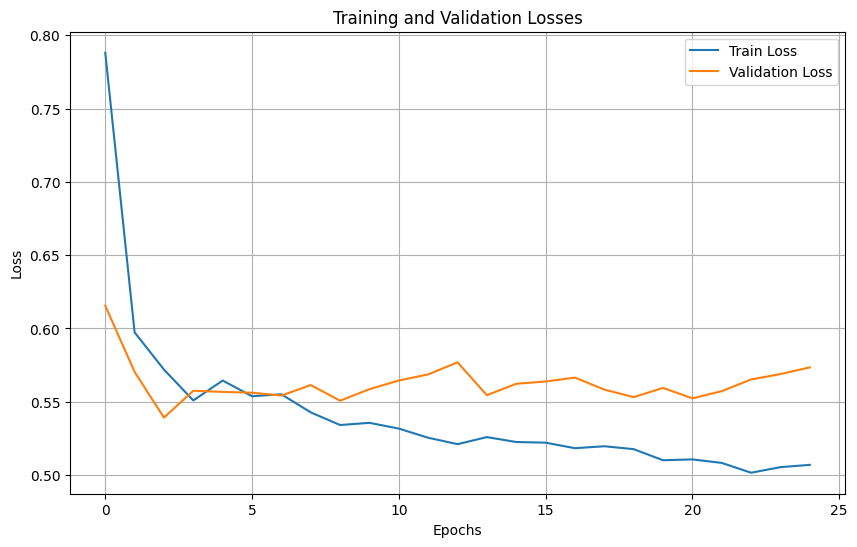

In [18]:
# Plotta as perdas de treino e validação
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()